# The Muon Collection

Muons are single-track particles. They can be reconstructed from hits in the tracking, calorimeter, and, of course, the muons chambers. Like electrons, there are several versions of the same muons that one can access (`Tight`, `Medium`, etc.).


In [1]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21
import matplotlib.pyplot as plt
from config import ds_zmumu as ds
import awkward as ak
import numpy as np

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


The default muon we fetch is the so-called `Medium` muon with `NonIso` isolation. Unfortunately, the MC we are working with for this demo contains very few muons!

In [2]:
muons = (ds
        .SelectMany(lambda e: e.Muons("Muons"))
        .Where(lambda m: (m.pt() / 1000) > 30)
        .Select(lambda m: m.pt() / 1000.0)
        .AsAwkwardArray('pt')
        .value())

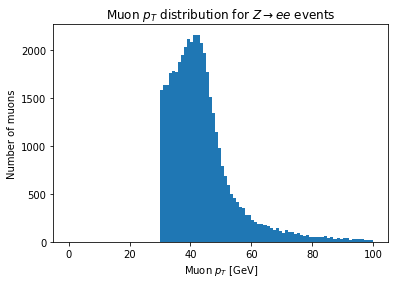

In [3]:
plt.hist(muons.pt, bins=100, range=(0, 100))
plt.xlabel('Muon $p_T$ [GeV]')
plt.ylabel('Number of muons')
_ = plt.title('Muon $p_T$ distribution for $Z\\rightarrow ee$ events')

## Muon Types

Muons come in several different flavors. In this sample with very few muons, we can look at the different $\eta$ distributions for what muons are there:

In [4]:
muons = (ds
        .Select(lambda e: {
            'tight_eta': e.Muons("Muons", working_point='Tight').Select(lambda m: m.eta()),
            'loose_eta': e.Muons("Muons", working_point='Loose').Select(lambda m: m.eta()),
            'medium_eta': e.Muons("Muons", working_point='Medium').Select(lambda m: m.eta()),
        })
        .AsAwkwardArray()
        .value())

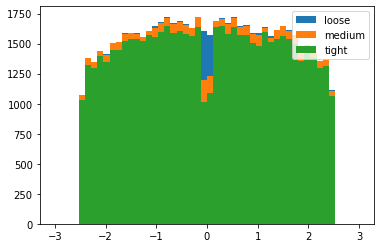

In [5]:
plt.hist(ak.flatten(muons.loose_eta), bins=50, range=(-3, 3), label='loose')
plt.hist(ak.flatten(muons.medium_eta), bins=50, range=(-3, 3), label='medium')
plt.hist(ak.flatten(muons.tight_eta), bins=50, range=(-3, 3), label='tight')
plt.legend()

## Calibration

By default the muons we pulled are `Medium` quality and calibrated. One can request different systematic errors using the `calibration` argument to the `Muons` method.

In [6]:
muons = (ds
        .Select(lambda e: e.Muons("Muons"))
        .Select(lambda muons: {
            'pt': muons.Select(lambda m: m.pt() / 1000.0),
            'eta': muons.Select(lambda m: m.eta()),
            'phi': muons.Select(lambda m: m.phi()),
        })
        .AsAwkwardArray()
        .value())

To grab the raw jets (without calibration) we just set the `calibrated` parameter to `None` (there is very little reason one will do this normally):

In [7]:
raw_muons = (ds
             .Select(lambda e: e.Muons("Muons", calibration=None))
             .Select(lambda muons: {
                 'pt': muons.Select(lambda m: m.pt() / 1000.0),
                 'eta': muons.Select(lambda m: m.eta()),
                 'phi': muons.Select(lambda m: m.phi()),
             })
             .AsAwkwardArray()
             .value())

The number of raw jets and the number of calibrated jets are quite different from the number of raw jets, so we'll need to match them in $\eta$ and $\phi$:

In [8]:
len(raw_muons), len(muons)

(50000, 50000)

In [9]:
def match(jets, jets_to_match):
    'Find the closest eta/phi jet in jets_to_match for each jet in jets'

    to_match_pt = jets_to_match.pt
    to_match_eta = jets_to_match.eta
    to_match_phi = jets_to_match.phi
    jet_eta = jets.eta
    jet_phi = jets.phi

    pair_eta = ak.cartesian([jet_eta, to_match_eta], axis=1, nested=True)
    pair_phi = ak.cartesian([jet_phi, to_match_phi], axis=1, nested=True)

    delta_eta = np.abs(pair_eta[:, :, :]["0"] - pair_eta[:, :, :]["1"])
    # TODO: Missing wrap around fro phi
    delta_phi = np.abs(pair_phi[:, :, :]["0"] - pair_phi[:, :, :]["1"])

    delta = delta_eta**2 + delta_phi**2

    # TODO: remove anything larger that 0.2*0.2
    best_match = ak.argmin(delta, axis=2)

    return ak.Record({"eta": to_match_eta[best_match], "phi": to_match_phi[best_match], "pt": to_match_pt[best_match]})

raw_muons_matched = match(muons, raw_muons)

Note the units along the x-axis here!! We are using **MeV** not *GeV*!

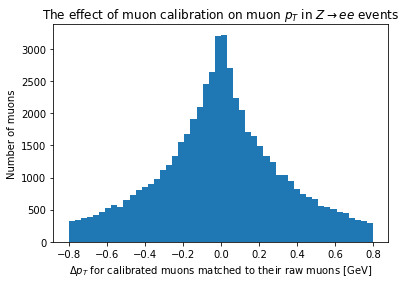

In [10]:
plt.hist(ak.flatten(muons.pt-raw_muons_matched.pt), bins=50, range=(-0.8, 0.8))
plt.xlabel('$\Delta p_T$ for calibrated muons matched to their raw muons [GeV]')
plt.ylabel('Number of muons')
_ = plt.title('The effect of muon calibration on muon $p_T$ in $Z\\rightarrow ee$ events')

If we instead want a particular systematic error, we need only name that error to get it back. Knowing what the names of the systematic errors, however, is not something that can be programmatically determined ahead of time. See the further information section at the end of this chapter to links to the ATLAS muon calibration info twiki.

In [11]:
sys_muon = (ds
           .Select(lambda e: e.Muons("Muons", calibration="MUON_ID__1up"))
           .Select(lambda muons: {
               'pt': muons.Select(lambda m: m.pt() / 1000.0),
               'eta': muons.Select(lambda m: m.eta()),
               'phi': muons.Select(lambda m: m.phi()),
           })
           .AsAwkwardArray()
           .value())

In [12]:
sys_muons_matched = match(muons, sys_muon)

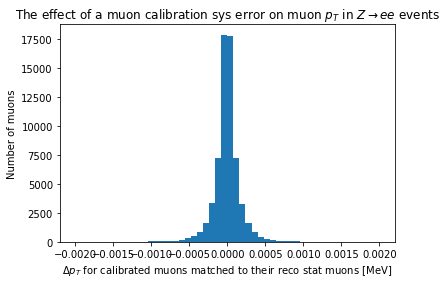

In [13]:
plt.hist(ak.flatten(muons.pt-sys_muons_matched.pt)/1000.0, bins=50, range=(-0.002, 0.002))
plt.xlabel('$\Delta p_T$ for calibrated muons matched to their reco stat muons [MeV]')
plt.ylabel('Number of muons')
_ = plt.title('The effect of a muon calibration sys error on muon $p_T$ in $Z\\rightarrow ee$ events')

## The Data Model

The data model when this documentation was last built is.

In [14]:
from func_adl_servicex_xaodr21.xAOD.muon_v1 import Muon_v1
help(Muon_v1)

Help on class Muon_v1 in module func_adl_servicex_xaodr21.xAOD.muon_v1:

class Muon_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  charge(self) -> 'float'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  cluster(self) -> 'func_adl_servicex_xaodr21.xAOD.calocluster_v1.CaloCluster_v1'
 |      A method
 |  
 |  clusterLink(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_calocluster_v1__.ElementLink_DataVector_xAOD_CaloCluster_v1__'
 |      A method
 |  
 |  combinedTrackParticleLink(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_trackparticle_v1__.ElementLink_DataVector_xAOD_TrackParticle_v1__'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  extrapolatedMuonSpectrometerTrackParticleLink(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_trackparticle_v1__.ElementLink_DataVector_xAOD_TrackParticle_v1__'
 |      A me

## Further Information

* The [`xAOD::Muon_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODMuon/xAODMuon/versions/Muon_v1.h) with all the inline documentation.
* The [Muon Recommendation Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/MCPAnalysisGuidelinesMC16) on the ATLAS TWiki